In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from src.configspace import (
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SVR_CONFIGSPACE,
    XGB_CONFIGSPACE,
)
from src.constant import (
    HO,
    PROCESSED_DATA_DIR,
    RANDOM_STATE_LIST,
    RESULTS_BASE_DIR,
    SOLVER_NUMBER_LIST,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.model import (
    SVR,
    GPRWithRBF,
    PolynomialRidge,
    RandomForestRegressor,
    Ridge,
    XGBRegressor,
)
from src.results import plot_line, plot_scatter, wilcoxon_df
from src.split import get_n_splits
from src.wrapper import ScikitLearnWrapper

In [3]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [4]:
SPLITS = get_n_splits(
    df=df,
    n=HO.N,
    instance_number=HO.INSTANCE_NUMBER,
    solver_number=HO.SOLVER_NUMBER,
    random_state=HO.RANDOM_STATE,
)

### Ridge

In [5]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_BASE_DIR / "HO" / "ridge_incumbent.pkl",
)
ridge_incumbent

{'alpha': 194.2586877757369,
 'random_state': 0,
 'model_cls': sklearn.linear_model._ridge.Ridge}

### PolynomialRidge

In [6]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_BASE_DIR / "HO" / "poly_ridge_incumbent.pkl",
)
poly_ridge_incumbent

{'alpha': 999.9983822453312,
 'degree': 2,
 'interaction_only': False,
 'model_cls': src.model.PolynomialRidge}

### RandomForestRegressor

In [7]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_BASE_DIR / "HO" / "rf_incumbent.pkl",
)
rf_incumbent

{'ccp_alpha': 0.0010550682433,
 'max_depth': 11,
 'max_features': 0.5492108995022,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_jobs': -1,
 'random_state': 0,
 'model_cls': sklearn.ensemble._forest.RandomForestRegressor}

### XGBRegressor

In [8]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_BASE_DIR / "HO" / "xgb_incumbent.pkl",
)
xgb_incumbent

{'colsample_bytree': 0.6334392605349,
 'gamma': 3.1028234772384,
 'learning_rate': 0.001846333114,
 'max_depth': 5,
 'min_child_weight': 9,
 'n_estimators': 501,
 'reg_alpha': 6.9167496732409,
 'reg_lambda': 9.7078357604554,
 'seed': 0,
 'subsample': 0.8860676749609,
 'model_cls': xgboost.sklearn.XGBRegressor}

### SVR

In [9]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_BASE_DIR / "HO" / "svr_incumbent.pkl",
)
svr_incumbent

{'C': 3.4469281701267,
 'kernel': 'rbf',
 'max_iter': 100000,
 'tol': 0.0091222119776,
 'gamma': 'scale',
 'model_cls': sklearn.svm._classes.SVR}

### GPRWithRBF

In [10]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_BASE_DIR / "HO" / "gpr_incumbent.pkl",
)
gpr_incumbent

{'alpha': 0.0999988005833,
 'length_scale': 4.8259955614628,
 'length_scale_bounds': 'fixed',
 'model_cls': src.model.GPRWithRBF}

## Comparison

In [11]:
model_info_list = [
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    }
]
 
# total_iterations = len(RANDOM_STATE_LIST) * len(SOLVER_NUMBER_LIST) * len(model_info_list)
# pbar = tqdm(total=total_iterations, desc="Evaluating models")

# records = []

# for random_state in RANDOM_STATE_LIST:
#     for solver_number in SOLVER_NUMBER_LIST:
#         pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
#         splits = get_n_splits(
#             df,
#             n=5,
#             instance_number=10,
#             solver_number=solver_number,
#             random_state=random_state,
#         )
#         for model_info in model_info_list:
#             pbar.set_postfix(model=model_info["name"])

#             result = evaluate_model_with_cross_validation(
#                 df,
#                 wrapper=model_info["wrapper"],
#                 splits=splits,
#                 random_state=random_state,
#             )
#             result["random_state"] = random_state
#             result["solver_number"] = solver_number
#             result["name"] = model_info["name"]
#             records.append(result)
#             pbar.update(1)

# pbar.close()
# result_df = pd.DataFrame(records)
# result_df.to_pickle(RESULTS_BASE_DIR / "results.gzip", compression="gzip")

result_df = pd.read_pickle(RESULTS_BASE_DIR / "results.gzip", compression="gzip")

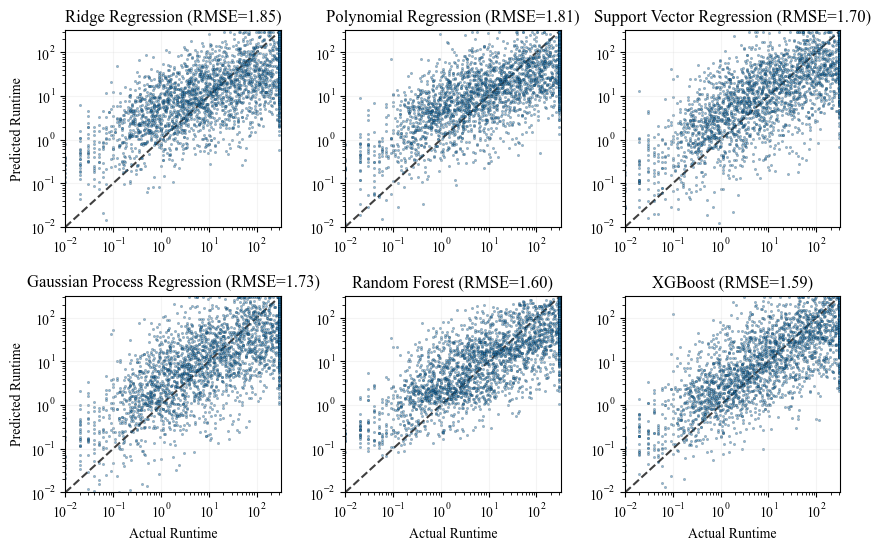

In [29]:
plot_df = result_df.loc[(result_df["random_state"] == 17) & (result_df["solver_number"] == 300)].reset_index(drop=True)

fig, axs = plot_scatter(plot_df)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

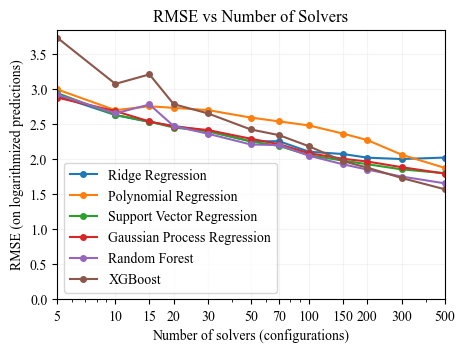

In [30]:
fig, ax = plot_line(result_df)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
styled_result = wilcoxon_df(result_df, model_info_list)
styled_result

solver_number,5,10,15,20,30,50,70,100,150,200,300,500
name,,,,,,,,,,,,
Ridge Regression,2.905,2.630,2.530,2.475,2.401,2.254,2.256,2.106,2.073,2.022,2.002,2.023
Polynomial Regression,2.995,2.699,2.754,2.731,2.700,2.593,2.539,2.480,2.363,2.272,2.065,1.876
Support Vector Regression,2.944,2.630,2.535,2.451,2.399,2.253,2.189,2.056,1.979,1.928,1.855,1.800
Gaussian Process Regression,2.879,2.685,2.538,2.465,2.416,2.292,2.214,2.084,2.005,1.966,1.886,1.795
Random Forest,2.923,2.653,2.779,2.472,2.363,2.210,2.201,2.048,1.927,1.851,1.753,1.657
XGBoost,3.734,3.073,3.209,2.784,2.653,2.423,2.343,2.183,1.970,1.879,1.732,1.572
